# Deep Q-Learning for Enduro
This notebook implements and optimizes the Deep Q-Network (DQN) proposed by [Mnih et al.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) to play the Atari game, Enduro.  The implmentation was inspired by this [repository](https://github.com/Curt-Park/rainbow-is-all-you-need) of a basic DQN architecture. The game is simulated through environments made available by Open-AI's [gym](https://gymnasium.farama.org/environments/atari/) API.



# Install necessary packages

We will be reverting to an older version of the gym API to resolve compatability issues.

In [8]:
!pip install gym
!pip install --upgrade gym==0.19.0
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install typing-extensions --upgrade

  Using cached gym-0.19.0.tar.gz (1.6 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Import libraries and set RNG seed for reproducability

In [9]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import collections
import cv2

import gym
from gym.wrappers import GrayScaleObservation, FrameStack, RecordVideo

import os
import logging
import matplotlib.pyplot as plt

torch.manual_seed(1)

# DQN Agent

This class creates the evaluation and target networks and the experience replay mechanism. Both are suggested by the paper and should help the network better converge.

The evaluation network computes the current action-value (Q) according to the current states, whereas the target network computes a hypothetical run based on the next states; the target network is only updated at a specified frequency as to ensure the network can converge and not chase a continuously moving target.

The experience replay mechanism randomly samples previous transitions to minimize the issue of highly correlated data in reinforcement learning.

In [10]:
class DQNAgent:
    def __init__(
            self, input_shape, action_shape, gamma, epsilon, learning_rate,
            batch_size=32, memory_size=10000, epsilon_minimum=0.01,
            epsilon_decrement=1e-5, target_replace_frequency=1000,
            checkpoint_dir='temp/'
    ):
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_minimum = epsilon_minimum
        self.epsilon_decrement = epsilon_decrement
        self.target_replace_frequency = target_replace_frequency
        self.checkpoint_dir = checkpoint_dir

        self.action_space = [i for i in range(action_shape)]
        self.batch_space = [i for i in range(self.batch_size)]
        self.current_step = 0

        self.replay_memory = Memory(memory_size, input_shape)
        self.eval_network, self.target_network = self.create_networks(
            input_shape, action_shape, learning_rate
        )

    def create_networks(self, *args, **kwargs):
        return (
            DeepQNetwork(*args, **kwargs, checkpoint_file=self.checkpoint_dir + 'dqn_eval'),
            DeepQNetwork(*args, **kwargs, checkpoint_file=self.checkpoint_dir + 'dqn_target')
        )

    # Epsilon greedy policy
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)

        state = torch.tensor([observation], dtype=torch.float)
        state = state.to(self.eval_network.device)
        actions = self.eval_network.forward(state)
        return torch.argmax(actions).item()

    # Check whether to update target network
    def replace_target_network(self):
        if self.current_step % self.target_replace_frequency == 0:
            self.target_network.load_state_dict(self.eval_network.state_dict())

    def decrement_epsilon(self):
        if self.epsilon > self.epsilon_minimum:
            self.epsilon -= self.epsilon_decrement
        else:
            self.epsilon = self.epsilon_minimum

    def save_networks(self):
        self.target_network.save_checkpoint()
        self.eval_network.save_checkpoint()

    def load_networks(self):
        self.target_network.load_checkpoint()
        self.eval_network.load_checkpoint()

    def save_to_memory(self, state, action, reward, new_state, done):
        self.replay_memory.save(state, action, reward, new_state, done)

    def sample_memory(self):
        state, action, reward, new_state, done = self.replay_memory.sample(self.batch_size)
        return (
            self.eval_network.to_tensor(state),
            self.eval_network.to_tensor(action),
            self.eval_network.to_tensor(reward),
            self.eval_network.to_tensor(new_state),
            self.eval_network.to_tensor(done)
        )

    def learn(self):

        # Fill all the replay memory before starting
        if self.replay_memory.memory_counter < self.batch_size * 10:
            return

        self.eval_network.optimizer.zero_grad()
        self.replace_target_network()
        states, actions, rewards, next_states, done_flags = self.sample_memory()

        # For each item in batch we need the action_value of the specific action
        action_values = self.eval_network.forward(states)
        action_values = action_values[self.batch_space, actions]

        # We need the next state max action values. We forward next_states,
        # through the target network, take a max over the action dimension
        # and return the first value of the tuple (value, indices)
        # Doc here: https://pytorch.org/docs/master/generated/torch.max.html#torch.max
        action_values_next = self.target_network.forward(next_states)
        action_values_next = action_values_next.max(dim=1)[0]

        # Mask everything that is done to zero
        action_values_next[done_flags] = 0.0

        # Calculate target action value using the equation:
        action_value_target = rewards + self.gamma * action_values_next

        # Propagate errors and step
        self.eval_network.backward(action_value_target, action_values)
        self.decrement_epsilon()
        self.current_step += 1

# Modify Environment
Several modifications were done on the environment to accomodate the proposed methodology in the paper, for training efficiency.


* Repeat a single action four times instead of executing an action per frame
* Use the maximum pixel value from the last two frames to prevent jitter
* Convert RGB input into Grayscale
* Resize raw frames to 84 x 84 then normalize
* Stack the last four frames as the input to the Q-function





In [11]:
class RepeatActionInFramesTakeMaxOfTwo(gym.Wrapper):
    def __init__(self, env, repeat=4):
        super().__init__(env)

        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frames = collections.deque(maxlen=2)

        if repeat <= 0:
            raise ValueError('Repeat value needs to be 1 or higher')

    def step(self, action):

        total_reward = 0
        done = False
        info = {}

        for i in range(self.repeat):
            observation, reward, done, info = self.env.step(action)
            total_reward += reward
            self.frames.append(observation)

            if done:
                break

        # Open queue into arguments for np.maximum
        maximum_of_frames = np.maximum(*self.frames)
        return maximum_of_frames, total_reward, done, info

    def reset(self):
        observation = self.env.reset()
        self.frames.clear()
        self.frames.append(observation)
        return observation


class NormResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)

        self.shape = shape

        # Create the new observation space for the env
        # Since we are converting to grayscale we set low of 0 and high of 1
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=self.shape, dtype=np.float32
        )

    def observation(self, observation):
        """Change from 255 grayscale to 0-1 scale
        """
        observation = cv2.resize(observation, self.shape, interpolation=cv2.INTER_AREA)
        return (observation / 255.0).reshape(self.shape)

def prep_environment(env, shape, repeat):
    env = RepeatActionInFramesTakeMaxOfTwo(env, repeat)
    env = GrayScaleObservation(env)
    env = NormResizeObservation(env, shape)
    return FrameStack(env, num_stack=repeat)

# Replay Memory
A part of the experience replay mechanism. It stores the agent's recent past experiences (current state, current action, current reward, and next state) at each times step.

In [12]:
class Memory:
    def __init__(self, memory_size, input_shape):

        # state, action, reward, next_state, done
        memory_shape = [
            ('state', np.float32, input_shape), ('action', np.int64),
            ('reward', np.float32), ('next_state', np.float32, input_shape),
            ('done', bool)
        ]

        # Numpy record structure array allows, different data types
        # but with also batching ability
        self.memory = np.zeros(memory_size, dtype=memory_shape)
        self.memory_size = memory_size
        self.memory_counter = 0

    def save(self, state, action, reward, next_state, done):
        """Save the transition of the into the buffer
        """
        index = self.memory_counter % self.memory_size
        self.memory[index] = (state, action, reward, next_state, done)
        self.memory_counter += 1

    def sample(self, batch_size):
        """Return a sample of batch_size given from memory. We do not use replace
        so the samples are unique.
        """
        maximum_current_memory = min(self.memory_counter, self.memory_size)
        indices = np.random.choice(maximum_current_memory, batch_size, replace=False)
        batch = self.memory[indices]

        return (
            np.array(batch['state']),
            np.array(batch['action']),
            np.array(batch['reward']),
            np.array(batch['next_state']),
            np.array(batch['done'])
        )

# Deep Q-Network

Consists of 3 convolutional layers followed by 2 fully connected layers. Each layer, except the final FC, is equipped with a ReLU activation.


In [13]:
class DeepQNetwork(nn.Module):
    def __init__(self, input_shape, output_shape, learning_rate, checkpoint_file):
        super().__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.learning_rate = learning_rate
        self.checkpoint_file = checkpoint_file

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, 8, stride=4) # input_dims[0] = channel
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)

        flattened_shape = self.calculate_flattened_shape(self.input_shape)

        self.fc1 = nn.Linear(flattened_shape, 512)
        self.fc2 = nn.Linear(512, output_shape)

        self.loss = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.parameters(), lr=self.learning_rate)
        self.device = self.get_device()
        self.to(self.device)

    @staticmethod
    def get_device():
        device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        device = torch.device(device_name)
        logging.info(f'Using device: {device}')
        return device

    def calculate_flattened_shape(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.size()))

    def save_checkpoint(self):
        logging.info('Saving checkpoint')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        logging.info('Loading checkpoint')
        self.load_state_dict(torch.load(self.checkpoint_file))

    def to_tensor(self, inputs):
        return torch.tensor(inputs).to(self.device)

    def forward(self, inputs):
        # Convolutions
        x = f.relu(self.conv1(inputs))
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        # Flatten
        x = x.view(x.size()[0], -1)
        # Linear layers
        x = f.relu(self.fc1(x))
        return self.fc2(x)

    def backward(self, target, value):
        loss = self.loss(target, value).to(self.device)
        loss.backward()
        self.optimizer.step()

# Main

Save the target and evaluation network when a highest score is achieved.

Record and save the environment of the final game.

Log the score, (rolling) average score, and best score after each game/episode

In [14]:
if __name__ == '__main__':
    repeat = 4
    frame_shape = (84, 84)
    gamma = 0.99                # discount factor
    epsilon = 1                 # starting epsilon
    learning_rate = 0.0002
    games = 50
    rolling_average_n = 25
    directory = 'temp/'

    if not os.path.exists(directory):
        raise NotADirectoryError('Folder specified to save assets does not exist')

    env = gym.make('EnduroNoFrameskip-v4')
    env = prep_environment(env, frame_shape, repeat)

    agent = DQNAgent(
        input_shape=env.observation_space.shape,
        action_shape=env.action_space.n,
        gamma=gamma,
        epsilon=epsilon,
        learning_rate=learning_rate,
        checkpoint_dir=directory
    )

    best_score = 0
    scores, steps, rolling_means, epsilons = [], [], [], []
    current_step = 0

    for episode in range(games):

        # Record video of last game
        if episode == games - 1:
            video_name = f'{directory}dqn_agent_enduro_video'
            env = RecordVideo(env, video_name)

        done = False
        score = 0
        observation = env.reset()

        while not done:
            action = agent.choose_action(observation)
            new_observation, reward, done, info = env.step(action)
            score += reward

            agent.save_to_memory(observation, action, reward, new_observation, done)
            agent.learn()
            observation = new_observation
            current_step += 1

        scores.append(score)
        steps.append(current_step)
        epsilons.append(agent.epsilon)

        rolling_mean = np.mean(scores[-rolling_average_n:])
        rolling_means.append(rolling_mean)

        # Log incremental progress
        print(f"Ep: {episode} | Score: {score} | Avg: {rolling_mean:.1f} | Best: {best_score:.1f}")

        if score > best_score:
            best_score = score
            agent.save_networks()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated

Ep: 0 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 1 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 2 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 3 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 4 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 5 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 6 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 7 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 8 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 9 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 10 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 11 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 12 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 13 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 14 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 15 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 16 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 17 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 18 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 19 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 20 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 21 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 22 | Score: 0.0 | Avg: 0.0 | Best: 0.0
Ep: 23 | Score: 0.0 |

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment EnduroNoFrameskip-v4 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metada

Ep: 49 | Score: 106.0 | Avg: 37.4 | Best: 119.0


# Plot: Average Total Reward and Epsilon across Total Steps
View the overall performance of the agent across 50 games

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


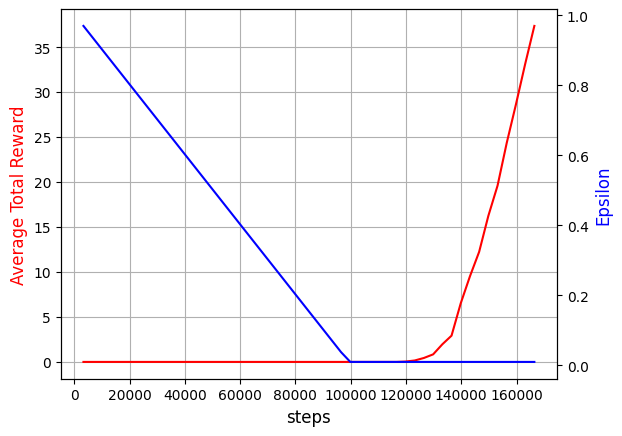

In [15]:
plot_name1 = f'{directory}avg_tot_reward.png'
fig, ax = plt.subplots()
ax.plot(steps, rolling_means, color="red")
ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel("Average Total Reward", color="red", fontsize=12)
plt.grid()
ax2 = ax.twinx()
ax2.plot(steps, epsilons, color="blue")
ax2.set_ylabel("Epsilon", color="blue", fontsize=12)
fig.savefig(plot_name1)

# Plot: Total Reward and Epsilon across Total Steps
Check for fluctutuations in agent's performance across 50 games

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


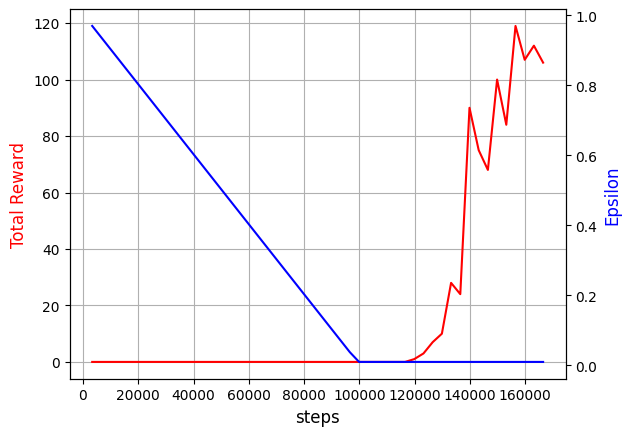

In [19]:
plot_name2 = f'{directory}tot_reward_plot.png'
fig, ax = plt.subplots()
ax.plot(steps, scores, color="red")
ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel("Total Reward", color="red", fontsize=12)
plt.grid()
ax2 = ax.twinx()
ax2.plot(steps, epsilons, color="blue")
ax2.set_ylabel("Epsilon", color="blue", fontsize=12)
fig.savefig(plot_name2)

# Plot: Total and Average Reward across Total Steps

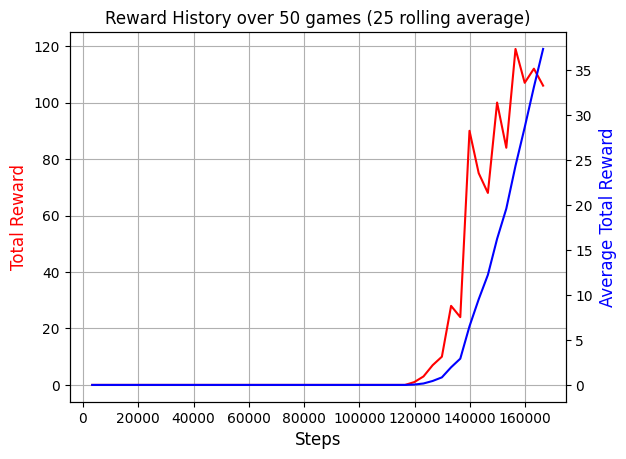

In [23]:
plot_name3 = f'{directory}combined_plot.png'
fig, ax = plt.subplots()
ax.plot(steps, scores, color="red")
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Total Reward", color="red", fontsize=12)
plt.grid()
ax2 = ax.twinx()
ax2.plot(steps, rolling_means, color="blue")
ax2.set_ylabel("Average Total Reward", color="blue", fontsize=12)
plt.title("Reward History over 50 games (25 rolling average)")
fig.savefig(plot_name3)